In [ ]:
!pip install ale-py
!pip install gym[accept-rom-license,atari]

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random
from gym import envs
import matplotlib.pyplot as plt
from matplotlib import animation
from keras.layers import Activation,Dense,Conv2D,Flatten,Input
from keras.models import Sequential,load_model,clone_model
from keras.optimizers import Adam
from keras import backend as K
import cv2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [ ]:
def resize_state(state):
    state = state[35:195,:]
    state = np.average(state,axis = 2)
    state = cv2.resize(state,(80,80),interpolation = cv2.INTER_NEAREST)
    state = np.array(state,dtype = np.uint8)
    return state

In [ ]:
def plot_state(state):
  plt.imshow(state)
  plt.axis("off")
  plt.show()

def update_scene(num,frames,patch):
  patch.set_data(frames[num])
  return patch

def plot_animation(frames):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anime = animation.FuncAnimation(
      fig,update_scene,fargs=(frames,patch),frames=len(frames),repeat=False,
      interval=40
  )
  plt.close()
  anime.save('show.gif',writer='imagemagick')
  return anime

In [ ]:
class Memory():
    def __init__(self,max_len):
        self.max_len = max_len
        self.states = deque(maxlen = max_len)
        self.actions = deque(maxlen = max_len)
        self.rewards = deque(maxlen = max_len)
        self.done = deque(maxlen = max_len)

    def remember(self, next_state, next_reward, next_action, next_done):
        self.states.append(next_state)
        self.actions.append(next_action)
        self.rewards.append(next_reward)
        self.done.append(next_done)

In [ ]:
class DQNAgent():
    def __init__(self,env):
        self.env = env
        self.state_shape = (80,80,4)
        self.action_space=[0,2,3]
        self.memory = Memory(max_len=100000)
        self.total_timesteps = 0
        self.gamma = 0.95  # discount
        self.epsilon = 1.0  # ε in ε-greedy strategy
        self.epsilon_decay = 0.9995  # ε decay
        self.epsilon_min = 0.05 # ε minimum value
        self.learning_rate = 0.0001  # learning rate
        self.model = self.build_model()
        self.target_model = clone_model(self.model)
        self.replay = []
        self.learns =0

    # Build neural network
    def build_model(self):
        model = Sequential()
        model.add(Input((80,80,4)))
        model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.action_space), activation = 'linear'))
        optimizer = Adam(self.learning_rate)
        model.compile(optimizer, loss=tf.keras.losses.Huber())
        model.summary()
        return model

    # Store experience into memory
    def remember(self, next_state, next_reward, next_action, next_done):
      self.memory.remember(next_state, next_reward, next_action, next_done)

    # Choose action using ε-greedy strategy
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 2, 3])
        q_values = self.model.predict(state)
        action = self.action_space[np.argmax(q_values)]
        return action

    # Update the target model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Train
    def train(self, batch_size=64):
      states = []
      next_states = []
      actions_taken = []
      next_rewards = []
      next_done = []

      while len(states) < batch_size:
          index = np.random.randint(4, len(self.memory.states) - 1)

          # Check if any of the done flags in the range [index-3, index] is True
          if any(self.memory.done[i] for i in range(index-3, index+1)):
              continue

          state = [self.memory.states[index-3],self.memory.states[index-2],self.memory.states[index-1],self.memory.states[index]]
          next_state = [self.memory.states[index-2],self.memory.states[index-1],self.memory.states[index],self.memory.states[index+1]]

          state = np.moveaxis(state, 0, 2) / 255.0
          next_state = np.moveaxis(next_state, 0, 2) / 255.0

          states.append(state)
          next_states.append(next_state)
          actions_taken.append(self.memory.actions[index])
          next_rewards.append(self.memory.rewards[index+1])
          next_done.append(self.memory.done[index+1])

      states = np.array(states)
      next_states = np.array(next_states)

      labels = self.model.predict(states)
      next_state_values = self.target_model.predict(next_states)

      for i in range(batch_size):
          action = self.action_space.index(actions_taken[i])
          labels[i][action] = next_rewards[i] + (1 - next_done[i]) * self.gamma * np.max(next_state_values[i])

      self.model.fit(states, labels, batch_size=batch_size, epochs=1, verbose = 0)

      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
      self.learns += 1

      if self.learns % 10000 == 0:
          self.target_model.set_weights(self.model.get_weights())



In [ ]:
import gc
last_100_avg = [-21]
scores = deque(maxlen=100)
max_score = -21
env = gym.make("PongDeterministic-v4",render_mode="rgb_array")
env.reset()
agent = DQNAgent(env)
# agent.model.load_weights('recent_weights.hdf5')

for i in range(1000):
    gc.collect()
    # Initialize a new game
    env.reset()
    starting_frame = resize_state(env.step(0)[0])

    dummy_action = 0
    dummy_reward = 0
    dummy_done = False
    for _ in range(3):
        agent.memory.remember(starting_frame, dummy_reward, dummy_action, dummy_done)

    done = False
    score = 0
    while True:
        # Update timesteps and save weights
        agent.total_timesteps += 1
        if agent.total_timesteps % 10000 == 0:
            agent.model.save_weights('recent_weights.h5')
            keras.backend.clear_session() # Prevent from RAM overflow
            agent.model.load_weights('recent_weights.h5')
            agent.target_model.set_weights(agent.model.get_weights())

            print('\nWeights saved!')
        # Take step
        next_state, next_reward, next_done, _ = env.step(agent.memory.actions[-1])

        # Get next state
        next_state = resize_state(next_state)
        new_state = [agent.memory.states[-3], agent.memory.states[-2], agent.memory.states[-1], next_state]
        new_state = np.moveaxis(new_state, 0, 2) / 255
        new_state = np.expand_dims(new_state, 0)

        # Get next action, using next state
        next_action = agent.choose_action(new_state)

        # If game is over, return the score
        if next_done:
            agent.memory.remember(next_state, next_reward, next_action, next_done)
            score += next_reward
            done = True
            break

        # Add the next experience to memory
        agent.memory.remember(next_state, next_reward, next_action, next_done)


        # If the threshold memory is satisfied, make the agent learn from memory
        if len(agent.memory.states) > 10000:
            agent.train()

        score += next_reward

    scores.append(score)
    if score > max_score:
        max_score = score
    if max_score > 20:
      print("Beat the computer at Episode"+str(i))
      print('Epsilon: ' + str(agent.epsilon))
    print('\nEpisode: ' + str(i))
    print('Score: ' + str(score))
    print('Max Score: ' + str(max_score))
    print('Epsilon: ' + str(agent.epsilon))



## Test the model


In [ ]:
env = gym.make("PongDeterministic-v4",render_mode="rgb_array")
env.reset()
agent = DQNAgent(env)
agent.model.load_weights('recent_weights.hdf5')
agent.epsilon = 0.049675

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 19, 19, 32)        8224      
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1180160   
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 1259683 (4.81 MB)
Trainable params: 1259

In [ ]:
env.reset()
starting_frame = resize_state(env.step(0)[0])
# done_flag=False
# states=[]
# temp=[]
# for i in range(4):
#   state, reward, done, _ = env.step(0)
#   state = resize_state(state)
#   temp.append(state)
# in_states=np.expand_dims(temp, 0)
# in_states=np.moveaxis(in_states,1,-1)
# states=temp
# frames=[]
# starting_frame = resize_state(env.step(0)[0])
score = -21
dummy_action = 0
dummy_reward = 0
dummy_done = False
final_frame = []
for _ in range(3):
  agent.memory.remember(starting_frame, dummy_reward, dummy_action, dummy_done)
while True:
  next_state, next_reward, next_done, _ = env.step(agent.memory.actions[-1])
  final_frame.append(next_state)
  # Get next state
  next_state = resize_state(next_state)
  new_state = [agent.memory.states[-3], agent.memory.states[-2], agent.memory.states[-1], next_state]
  new_state = np.moveaxis(new_state, 0, 2) / 255
  new_state = np.expand_dims(new_state, 0)

  # Get next action, using next state
  next_action = agent.choose_action(new_state)
  agent.memory.remember(next_state, next_reward, next_action, next_done)
  # If game is over, return the score
  if next_done:
      agent.memory.remember(next_state, next_reward, next_action, next_done)
      score += next_reward
      done = True
      break
# while done_flag==False:
#   state, reward, done, _=env.step(agent.choose_action(in_states))
#   done_flag = done
#   frames.append(state)
#   states=[states[1],states[2],states[3],resize_state(state)]
#   in_states= np.expand_dims(states, 0)
#   in_states=np.moveaxis(in_states,1,-1)
plot_animation(final_frame)



流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 45ms/step


##Final result

The DDQN model finally beat the computer from Episodes 145, but it took about 50 hours to acheive this stage.Since the time limit, we stopped training at this moment. And because of the resource limit on Google colab, we transfered the whole project to the server, with the environment as follow:
* GPU:Tesla T4(16GB) * 1
* CPU
8 vCPU Intel Xeon Processor (Skylake, IBRS)
* RAM:56GB
But we still optimized the model training to make sure it can be run on colab by using keras.backend.clear_session().

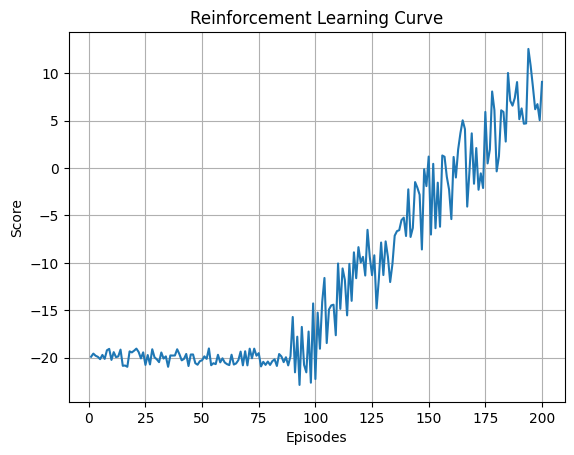

## Future Job
In order to address the issue of excessive training time, we have come across algorithms such as A3C (Asynchronous Advantage Actor-Critic) and GA3C (Generalized Advantage Estimation A3C), which utilize parallelism and multi-threading to effectively reduce training time. However, due to time constraints, we were unable to implement these algorithms in our current work. Therefore, we plan to explore the use of these algorithms in future research to improve training speed.

## References
https://gymnasium.farama.org/environments/atari/pong/

https://towardsdatascience.com/getting-an-ai-to-play-atari-pong-with-deep-reinforcement-learning-47b0c56e78ae

https://towardsdatascience.com/intro-to-reinforcement-learning-pong-92a94aa0f84d

https://pylessons.com/A3C-reinforcement-learning
